In [1]:
# Add the root path of the pyqula library
import os ; import sys
sys.path.append(os.environ["DMRGROOT"]) # add the library via environmental variable
# you have to install the dmrgpy library from
# https://github.com/joselado/dmrgpy
# and add its address to your python path (done above with an environmental variable)

# some default parameters in matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 22
plt.rcParams['image.cmap'] = 'coolwarm'


import numpy as np

# Matrix product states for spin chain models

### Learning outcomes
- Solve many-body spin models with tensor networks
- Understand the role of bond dimension in tensor networks
- Understand the role of spin-spin correlators in quantum spin models



## Energy of the Heisenberg model as a function of the system size
Let us first look at the many-body energy of the Heisenberg model as function of the system size

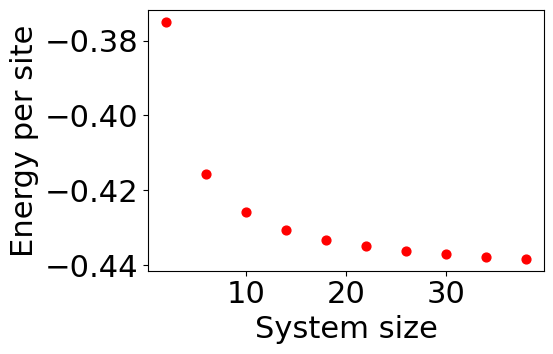

In [2]:
from dmrgpy import spinchain

def get_energy(N):
    """Return energies for a system fo size N"""
    spins = ["S=1/2" for i in range(N)] # S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    J = 1. # exchange coupling
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    sc.set_hamiltonian(h) # set the Hamiltonian
    return sc.gs_energy(mode="DMRG")/N # energy per site

plt.figure(figsize=(6,4))

Ns = [i for i in range(2,40,4)] # lengths of the system
es = [get_energy(N) for N in Ns] # ground state energy per site

plt.scatter(Ns,es,s=40,c="red") # plot the energies

plt.xlabel("System size") ; plt.ylabel("Energy per site") ;  plt.tight_layout()

### Quiz
- Why does the energy per site depend on the system size
- What would be the value in the thermodynamic limit?
- What is the biggest system that you could compute with exact diagonalization?

## Near lineal scaling with system size with matrix product states
We now show that matrix product states allow computing the ground state with a complexity that is linear with the system size

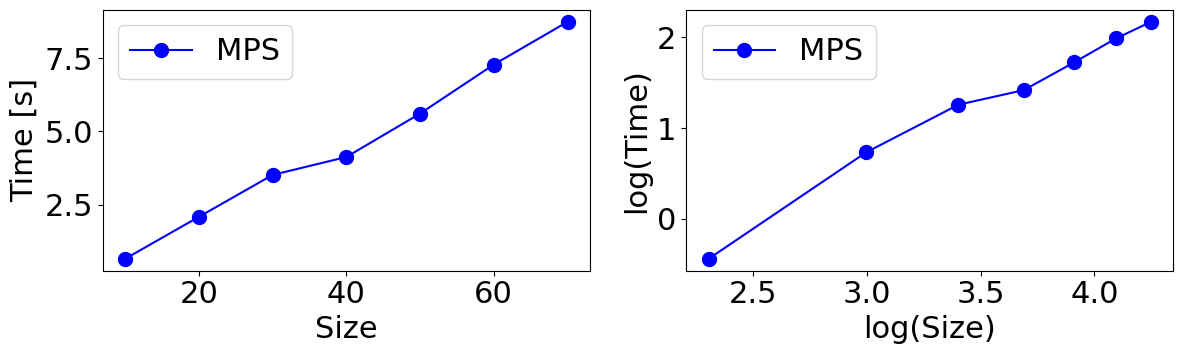

In [3]:
from dmrgpy import spinchain

def get_times(N):
    """Return time srequired for the calculation with ED and MPS"""
    spins = ["S=1/2" for i in range(N)] # S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    J = 1. # exchange coupling
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    import time
    sc.set_hamiltonian(h) # set the Hamiltonian
    t0mps = time.time() # initial time for MPS
    sc.maxm = 20 # not large bond dimension
    sc.get_gs(mode="DMRG") # compute ground state
    t1mps = time.time() # initial time for MPS
    return t1mps-t0mps # return MPS times

plt.figure(figsize=(12,4))

Ns = [i for i in range(10,80,10)] # lengths of the system
tsmps = [get_times(N) for N in Ns] # computational times

plt.subplot(1,2,1)
plt.plot(Ns,tsmps,markersize=10,c="blue",label="MPS",marker="o") # plot the MPS times
plt.xlabel("Size") ; plt.ylabel("Time [s]")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.log(Ns),np.log(tsmps),markersize=10,c="blue",label="MPS",marker="o") # plot the MPS times
plt.xlabel("log(Size)") ; plt.ylabel("log(Time)")
plt.legend()

plt.tight_layout()

### Quiz
- Why is the scaling linear with the system size if the Hilbert space has exponential dimension?
- How can you know that the ground state you got is accurate, and can you quantify this somehow?

## The role of the bond dimension
We will now see that the bond dimension control the accuracy of the calculation, by computing the fluctuation of the energy per site

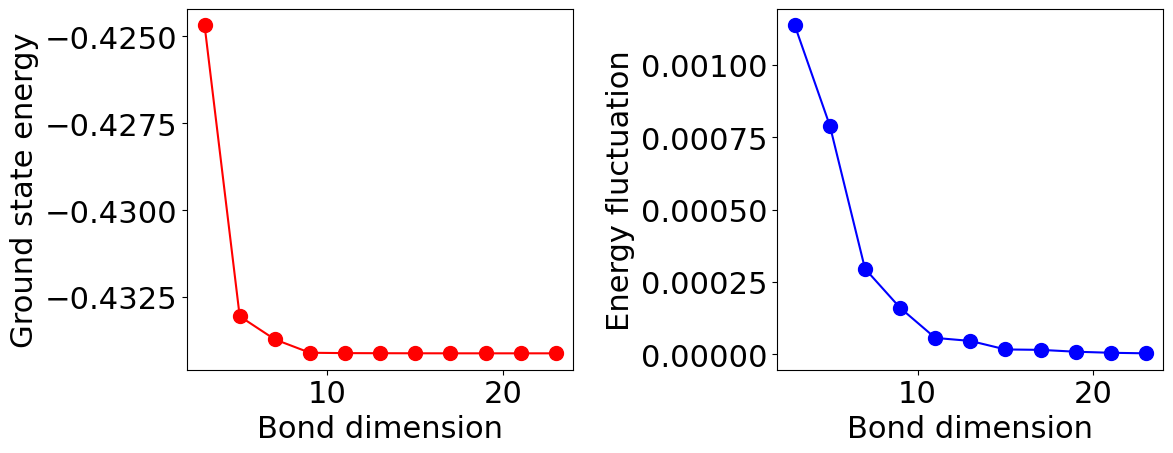

In [4]:
from dmrgpy import spinchain
import numpy as np
n= 20 # size of the chain
spins = ["S=1/2" for i in range(n)] # S=1/2 chain
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1):
    h = h + sc.Sx[i]*sc.Sx[i+1]
    h = h + sc.Sy[i]*sc.Sy[i+1]
    h = h + sc.Sz[i]*sc.Sz[i+1]
bds = range(3,24,2) # bond dimension
es,des = [],[] # storage of energies and fluctuations
for maxm in bds: # loop over bond dimension
    sc.set_hamiltonian(h) # create the Hamiltonian
    sc.maxm = maxm # set the bond dimension
    e = sc.gs_energy() # get the ground state energy
    wf = sc.get_gs() ; de = wf.dot(h*(h*wf)) # Energy square
    de = np.sqrt(np.abs(de-e**2)) # energy fluctuation
    es.append(e/n) # store energy
    des.append(de/n) # energy fluctuation
    
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(bds,es,c="red",marker="o",markersize=10)
plt.ylabel("Ground state energy")
plt.xlabel("Bond dimension")

plt.subplot(1,2,2)
plt.plot(bds,des,c="blue",marker="o",markersize=10)
plt.ylabel("Energy fluctuation")
plt.xlabel("Bond dimension")

plt.tight_layout()
plt.show()

### Quiz
- Which value of the bond dimension is enough to get an accurate ground state?
- What does it mean the energy of the fluctuation of the ground state?
- Make the system bigger, how do the previous plots behave, and why?

## The role of bond dimension in excited states
Let us now look at how excited states depend on the bonddimension of the matrix product state

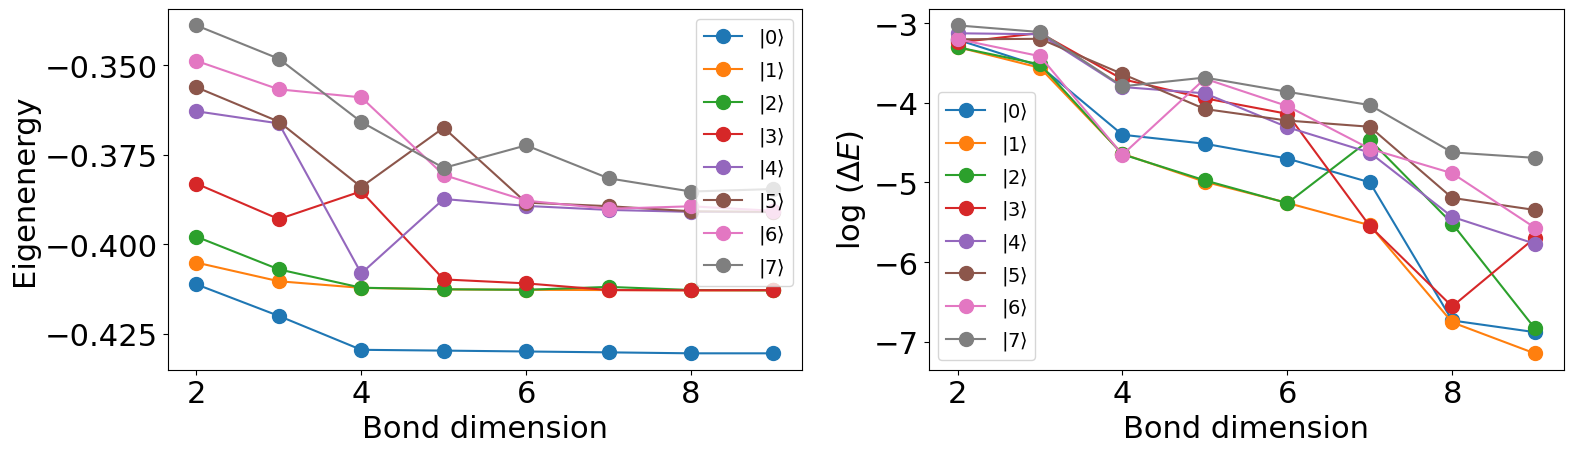

In [5]:
from dmrgpy import spinchain
import numpy as np
n= 14 # size of the chain
spins = ["S=1/2" for i in range(n)] # S=1/2 chain
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1):
    h = h + sc.Sx[i]*sc.Sx[i+1]
    h = h + sc.Sy[i]*sc.Sy[i+1]
    h = h + sc.Sz[i]*sc.Sz[i+1]

h2 = sc.toMPO(h)*sc.toMPO(h) # Hamiltonian square (to compute expectation values)
bds = range(2,10) # bond dimension
es,des = [],[] # storage of energies and fluctuations
for maxm in bds: # loop over bond dimension
    sc.set_hamiltonian(h) # create the Hamiltonian
    sc.maxm = maxm # set the bond dimension
    nex = 8 # number of excited states
    exs,wfs = sc.get_excited_states(mode="DMRG",n=nex,purify=False) # compute excited states
    esi,desi = [],[] # storage
    for (e,wf) in zip(exs,wfs): # loop over excited states
        e = wf.aMb(h,wf) # explicit energy
        de = wf.aMb(h2,wf) # Energy square
        de = np.sqrt(np.abs(de-e**2)) # energy fluctuation
        esi.append(e/n) # store energy
        desi.append(de/n) # energy fluctuation
    es.append(esi) # store energy
    des.append(desi) # store fluctuation

es = np.array(es) ; des = np.array(des) # to arrays

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
for i in range(nex): # loop over excited states
    plt.plot(bds,es[:,i],marker="o",markersize=10,label="|"+str(i)+"$\\rangle$")

plt.legend(fontsize=14)
plt.ylabel("Eigenenergy")
plt.xlabel("Bond dimension")

plt.subplot(1,2,2)
for i in range(nex): # loop over excited states
    plt.plot(bds,np.log(des[:,i]),marker="o",markersize=10,label="|"+str(i)+"$\\rangle$")

plt.legend(fontsize=14)
plt.ylabel("log ($\\Delta E$)")
plt.xlabel("Bond dimension")

plt.tight_layout()


### Quiz
- Which states converge faster with the bond dimension, and why?
- Which plot is most informative to know how converged the states are?
- Add a magnetic field to the Hamiltonian, do the plots qualitatively change, and why?

## Low energy excitations of a Heisenberg model
We will now see what are the matrix elements between the ground state and the first excited state in a Heisenberg model

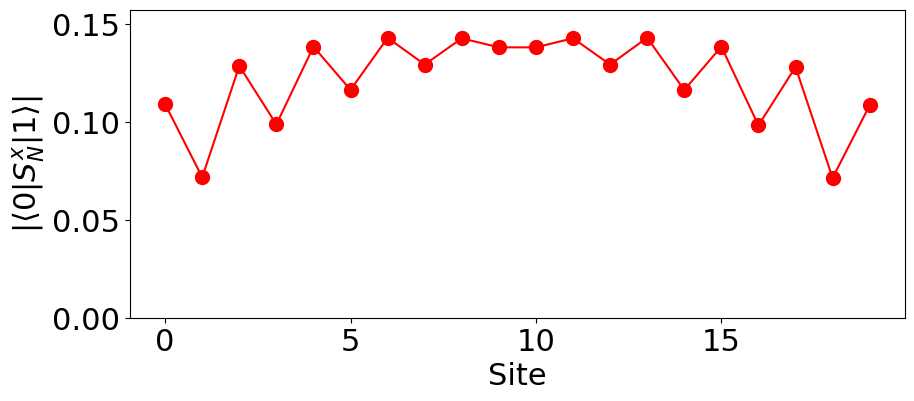

In [6]:
from dmrgpy import spinchain

L = 20 # number of spins
spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1): # Heisenberg coupling
    h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
Bz = 0.03 # small magnetic field
for i in range(len(spins)): h = h + Bz*sc.Sz[i] # and lets add a small magnetic field
sc.set_hamiltonian(h) # set the Hamiltonian

es,wfs = sc.get_excited_states(mode="DMRG",n=2)
wf0,wf1 = wfs[0],wfs[1] # lowest and first excited state


cs = [wf1.dot(sc.Sx[i]*wf0) for i in range(L)] # matrix elements between ground state and excited state

plt.figure(figsize=(10,4))
plt.plot(range(L),np.abs(cs),markersize=10,c="red",marker="o")
plt.xlabel("Site") ; plt.ylabel("$|\\langle 0|S^x_N|1\\rangle |$")
plt.ylim([0,max(np.abs(cs))*1.1])
plt.show()

### Quiz
- What is the physical interpretation of the previous profile?
- Why does the profile have a minimum at the edges and a maximum at the center?
- Make the system smaller, what happens?

## Level crossings as a function of the magnetic field with matrix product states
We will now show that as an external magnetic field is included, level crossings in the system take place leading to different ground states

Text(0, 0.5, '$B_z$')

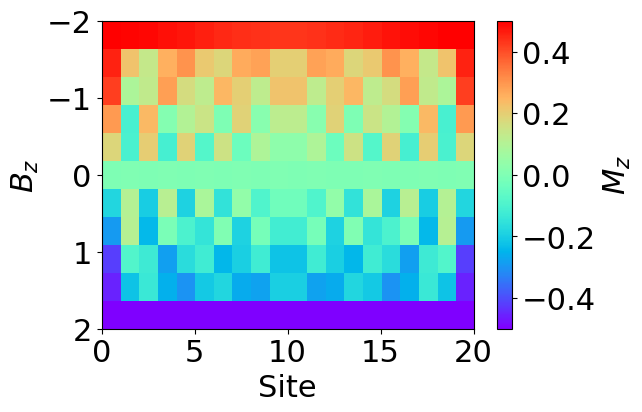

In [7]:
from dmrgpy import spinchain

L = 20 # number of spins

def get_mz(Bz):
    spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
    h = h + Bz*sum(sc.Sz) # add external field
    sc.set_hamiltonian(h) # set the Hamiltonian
    wf0 = sc.get_gs(mode="DMRG")
    return [wf0.dot(Szi*wf0).real for Szi in sc.Sz] # magnetization in each site



Bzs = np.linspace(-2.,2.,11,endpoint=True) # magnetic fields
Mzs = [get_mz(Bz) for Bz in Bzs] # compute magnetizations

plt.figure(figsize=(6,4))

plt.imshow(Mzs,aspect="auto",extent=[0,L,max(Bzs),min(Bzs)],vmin=-0.5,vmax=0.5,cmap="rainbow")
plt.colorbar(label="$M_z$") ; plt.xlabel("Site") ; plt.ylabel("$B_z$")

### Quiz
- Why does the magnetization saturate at high magnetic fields?
- Make the system smaller, what do you observe and why?

## Entanglement entropy of the ground state
We will now see how the entanglement entropy in each bond of the variational state depends on the bond dimension

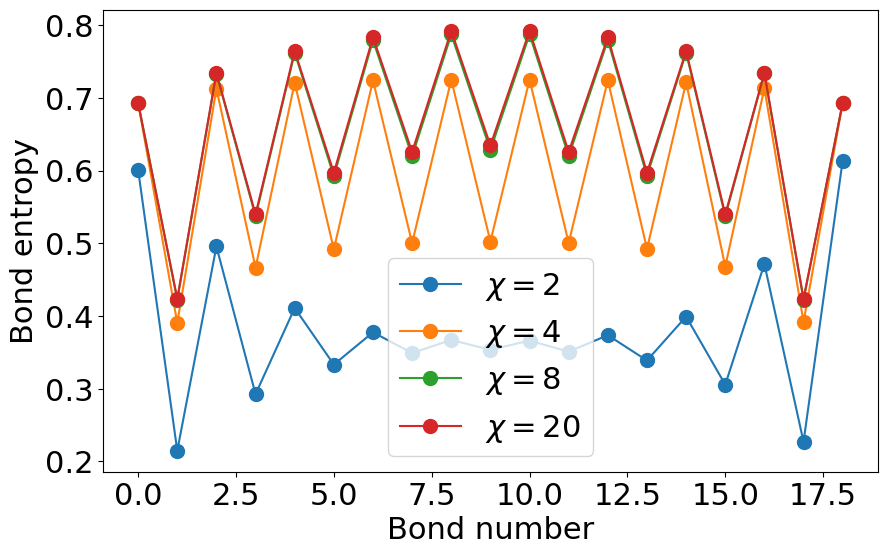

In [8]:
from dmrgpy import spinchain

def get_bond_entropies(maxm):
    L = 20 # 20 spins
    spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
    sc.maxm = maxm # set the bond dimension
    sc.set_hamiltonian(h) # set the Hamiltonian
    wf0 = sc.get_gs(mode="DMRG")
    return [wf0.get_bond_entropy(i-1,i) for i in range(1,L)]

plt.figure(figsize=(10,6))

for maxm in [2,4,8,20]:
    cs = get_bond_entropies(maxm) # matrix elements between ground state and excited state
    plt.plot(range(len(cs)),cs,markersize=10,marker="o",label="$\chi = $"+str(maxm))
    plt.xlabel("Bond number") ; plt.ylabel("Bond entropy")

plt.legend()

### Quiz
- Why does the entanglement entropy saturate with the bond dimension?
- Make the system bigger, how does the previous plot change, and why?
- What is the meaning of the bond entanglement entropy?
- Replace the Heisenberg model by an Ising model, how does the entanglement entropy change, and why?

## Size dependence of the entanglement entropy
We will now see that for a one dimensional system the entaglement entropy has a weak system size dependence

(0.0, 0.9776111297210376)

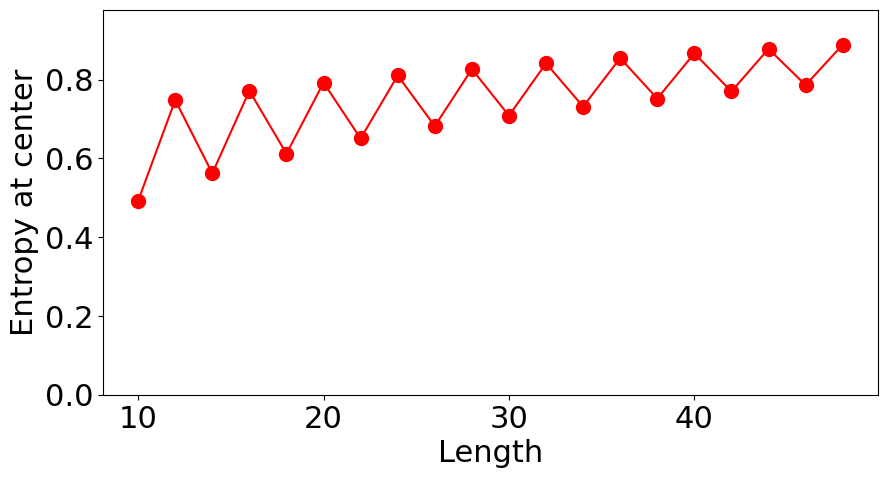

In [9]:
from dmrgpy import spinchain

def get_entropy(L=20):
    spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    J = -1 # exchange
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
    sc.set_hamiltonian(h) # set the Hamiltonian
    wf0 = sc.get_gs(mode="DMRG") # get ground state
    return wf0.get_bond_entropy(L//2,L//2+1)

Ls = range(10,50,2) # lengths
Ss = [get_entropy(L=L) for L in Ls] # entropies

plt.figure(figsize=(10,5))
plt.plot(Ls,Ss,markersize=10,marker="o",c="red")
plt.xlabel("Length") ; plt.ylabel("Entropy at center") ; plt.ylim([0,max(Ss)*1.1])



### Quiz
- Why does the entanglement entropy grow so slowly?
- Could you modify the Hamiltonian so that the growth is even slower, and if so, how?

## Open and closed boundary conditions
Let us now see which type of boundary condition creates more entropy

(0.0, 1.4466929229960934)

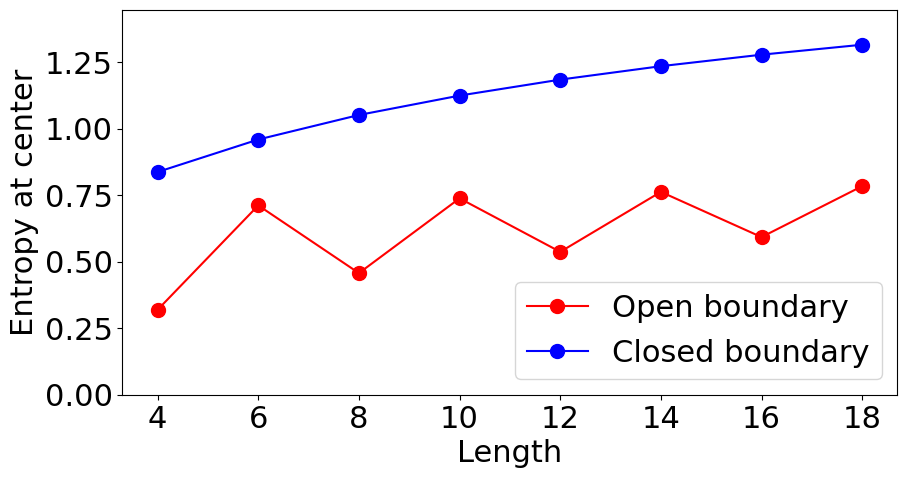

In [10]:
from dmrgpy import spinchain

def get_entropy(L=20,closed=True):
    spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    J = -1 # exchange
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
    if closed: # if closed boundary conditions
        h = h + sc.Sx[0]*sc.Sx[L-1] ; h = h + sc.Sy[0]*sc.Sy[L-1] ; h = h + sc.Sz[0]*sc.Sz[L-1]
    sc.set_hamiltonian(h) # set the Hamiltonian
    wf0 = sc.get_gs(mode="DMRG") # get ground state
    return wf0.get_bond_entropy(L//2-1,L//2)

Ls = range(4,20,2) # lengths
Ss_open = [get_entropy(L=L,closed=False) for L in Ls] # entropies
Ss_closed = [get_entropy(L=L,closed=True) for L in Ls] # entropies

plt.figure(figsize=(10,5))
plt.plot(Ls,Ss_open,markersize=10,marker="o",c="red",label="Open boundary")
plt.plot(Ls,Ss_closed,markersize=10,marker="o",c="blue",label="Closed boundary")
plt.legend()
plt.xlabel("Length") ; plt.ylabel("Entropy at center") 
plt.ylim([0,max(Ss_closed)*1.1])

### Quiz
- Which choice is more demanding from a computational point of view?
- If you remove one of the couplings in the middle of the chain, is it the same as removing the first to last? Why?
- Remove the XX and YY couplings, what has changed, and why?

## Bond dimension dependence of the entanglement entropy
We will now see how the entanglement entropy of a many-body state depends on the bond dimension of the matrix product state

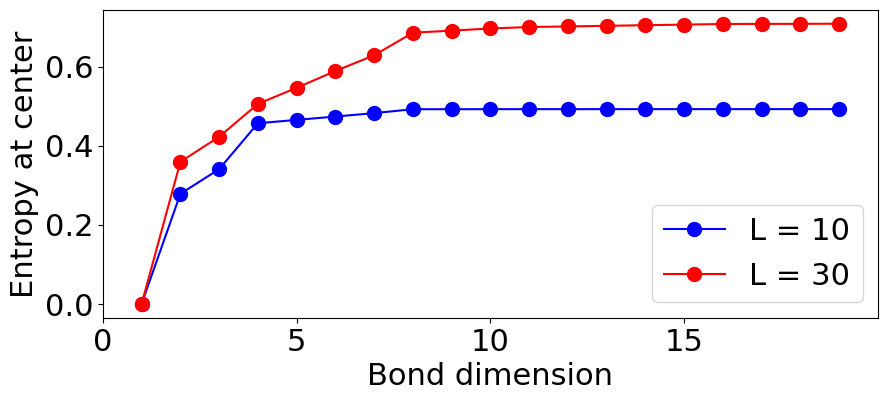

In [11]:
from dmrgpy import spinchain

def get_entropy(maxm=10,L=10):
    spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    J = -1 # exchange
    for i in range(len(spins)-1): # Heisenberg coupling
        h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
    sc.set_hamiltonian(h) # set the Hamiltonian
    sc.maxm = maxm
    wf0 = sc.get_gs(mode="DMRG") # get ground state
    return wf0.get_bond_entropy(L//2,L//2+1)

ms = range(1,20,1) # lengths
Ss0 = [get_entropy(maxm=m,L=10) for m in ms] # entropies
Ss1 = [get_entropy(maxm=m,L=30) for m in ms] # entropies

plt.figure(figsize=(10,4))
plt.plot(ms,Ss0,markersize=10,marker="o",c="blue",label="L = 10")
plt.plot(ms,Ss1,markersize=10,marker="o",c="red",label="L = 30")
plt.xlabel("Bond dimension") ; plt.ylabel("Entropy at center") ; plt.xlim([0,20]) ; plt.xticks(range(0,20,5))
plt.legend()


### Quiz
- Which ground state is more accurate at bond dimension 5?
- Make the system bigger, when does the entropy saturate and why?
- Remove the XX and YY couplings, what happens and why?

## The entanglement entropy as a signal for phase transitions
Let us now see that the entanglement entropy can be used to detect a quantum phase transition, in particular for the transverse field Ising model

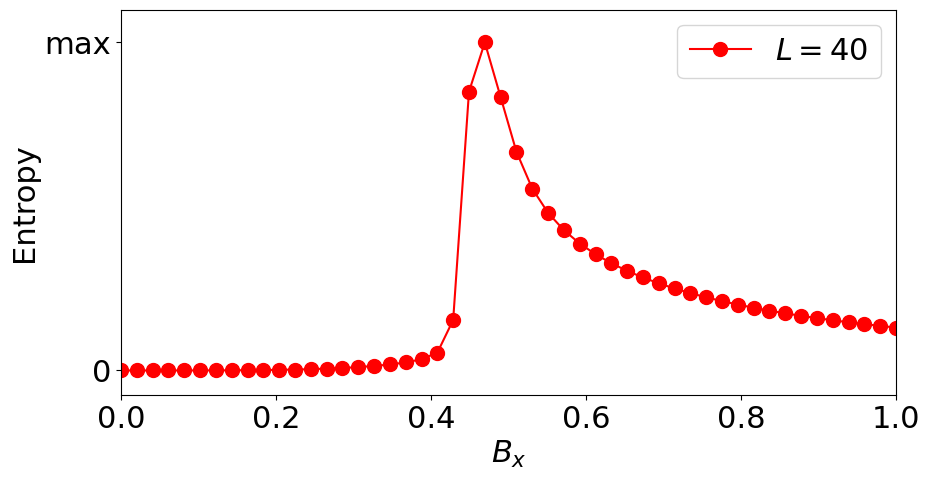

In [12]:
from dmrgpy import spinchain

def get_entropy(L=20,Bx=0.):
    spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    J = -1 # exchange
    for i in range(len(spins)-1): h = h + J*sc.Sz[i]*sc.Sz[i+1] # Ising coupling
    for i in range(L): h = h + Bx*sc.Sx[i] # tranverse field
    sc.set_hamiltonian(-sum(sc.Sz)) ; wfguess = sc.get_gs(mode="DMRG") # get a full ferro state
    sc.set_hamiltonian(h) # set the Hamiltonian
    wf0 = sc.get_gs(mode="DMRG",wf0=wfguess) # get ground state
    return wf0.get_bond_entropy(L//2,L//2+1)

plt.figure(figsize=(10,5))

Bxs = np.linspace(0.,1.,50,endpoint=True)
L = 40 # length of the system
ent = [get_entropy(L=L,Bx=Bx) for Bx in Bxs]
plt.plot(Bxs,ent,markersize=10,marker="o",label="$L = $"+str(L),c="red")
plt.xlabel("$B_x$") ; plt.ylabel("Entropy") ; plt.xlim([min(Bxs),max(Bxs)]) ; plt.ylim([-0.05,max(ent)*1.1])
plt.yticks(ticks=[0,max(ent)],labels=["0","max"])

plt.legend()

### Quiz
- Where do you think that the phase transition is in the thermodynamic limit?
- Why is the entanglement entropy small for small Bx and large Bx?
- Make the system smaller, what happens and why?
- Which region is the hardest to capture with matrix product states?

## Phase transition from the order parameter
We will now see how the same phase transition as above can be computed from the order parameter

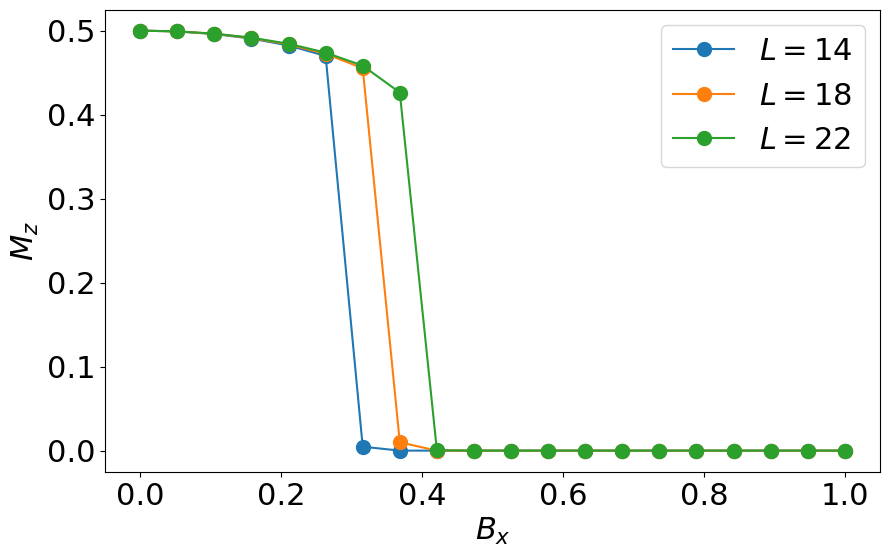

In [13]:
from dmrgpy import spinchain

def get_mz(L=20,Bx=0.):
    spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    J = -1. # exchange
    for i in range(len(spins)-1): h = h + J*sc.Sz[i]*sc.Sz[i+1] # Ising coupling
    for i in range(L): h = h + Bx*sc.Sx[i] # tranverse field
    sc.set_hamiltonian(-sum(sc.Sz)) ; wfguess = sc.get_gs(mode="DMRG") # get a full ferro state
    sc.set_hamiltonian(h) # set the Hamiltonian
    wf0 = sc.get_gs(mode="DMRG",wf0=wfguess) # get ground state, using wfguess as the guess
    return wf0.dot(sum(sc.Sz)*wf0).real/L # return magnetization

plt.figure(figsize=(10,6))

Bxs = np.linspace(0.,1.,20) # magnetic fields
Ls = [14,18,22] # lengths of the system

for L in Ls:
    mz = [get_mz(L=L,Bx=Bx) for Bx in Bxs]
    plt.plot(Bxs,mz,markersize=10,marker="o",label="$L = $"+str(L))
    plt.xlabel("$B_x$") ; plt.ylabel("$M_z$")

plt.legend()

### Quiz
- What is the ground state at each side of the transition?
- What would happen if you make the system bigger?
- Which is the hardest state to capture with matrix product states?

## Magnetization of moderately large Heisenberg model
Here we will show that a moderately large quantum Heisenberg model has zero magnetization

(0.0, 49.0)

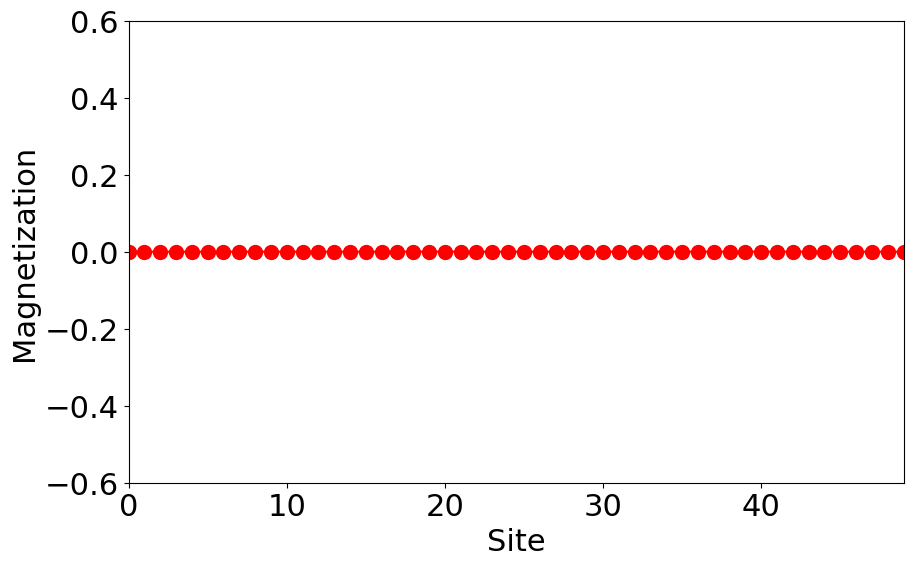

In [14]:
from dmrgpy import spinchain
n = 50 # number of sites
spins = ["S=1/2" for i in range(n)] # S=1/2 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
J = 1.0 # antiferromagnetic coupling, J=-1 for ferromagnetic coupling
Bz = -0.01 # small external magnetic field

for i in range(len(spins)-1): # Heisenber coupling
    h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    
for i in range(len(spins)): h = h + Bz*sc.Sz[i] # and lets add a small magnetic field

plt.figure(figsize=(10,6))
sc.set_hamiltonian(h) # set the Hamiltonian
iis = range(n)
cs = [sc.vev(sc.Sz[i]) for i in iis] # compute the vacuum expectation value

plt.plot(iis,cs,marker="o",c="red",markersize=10)
plt.xlabel("Site") ; plt.ylabel("Magnetization") ; plt.ylim([-0.6,0.6]) ; plt.xlim([min(iis),max(iis)])

### Quiz
- Why is the magnetization zero everywhere even though there is a small external magnetic field?
- Make the value of the exchange negative, what happens and why?
- Take the case with antiferromagnetic coupling, and increase the value of the magnetic field. When do you get a finite magnetization and why?

## Magnetization of a large Heisenberg model with a magnetic impurity
Here we will now add a magnetic impurity to a quantum Heisenberg model, and see how the magnetization decays with distance

(0.0, 39.0)

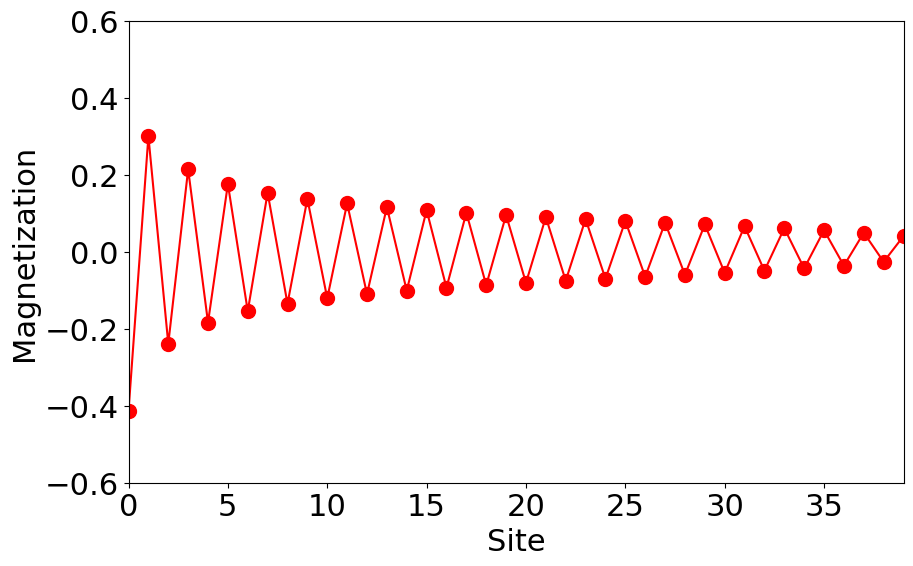

In [15]:
from dmrgpy import spinchain
n = 40 # length of the system
spins = ["S=1/2" for i in range(n)] # S=1 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1):
    h = h + sc.Sx[i]*sc.Sx[i+1]
    h = h + sc.Sy[i]*sc.Sy[i+1]
    h = h + sc.Sz[i]*sc.Sz[i+1]

    
Bz = 1. # local magnetization
h = h + Bz*sc.Sz[0]
    
sc.set_hamiltonian(h) # create the Hamiltonian
iis = range(n)
cs = [sc.vev(sc.Sz[i],mode="DMRG") for i in iis]

plt.figure(figsize=(10,6))
plt.plot(iis,cs,marker="o",c="red",markersize=10)
plt.xlabel("Site") ; plt.ylabel("Magnetization") ; plt.ylim([-0.6,0.6]) ; plt.xlim([min(iis),max(iis)])

### Quiz
- Why does the magnetization decay away from the magnetic site?
- Remove the XX and YY couplings. What happens and why?

## Magnetization of a dimerized Heisenberg model with a magnetic impurity
Here we will now add a magnetic impurity to a dimerized quantum Heisenberg model, and see how the magnetization decays with distance

(0.0, 39.0)

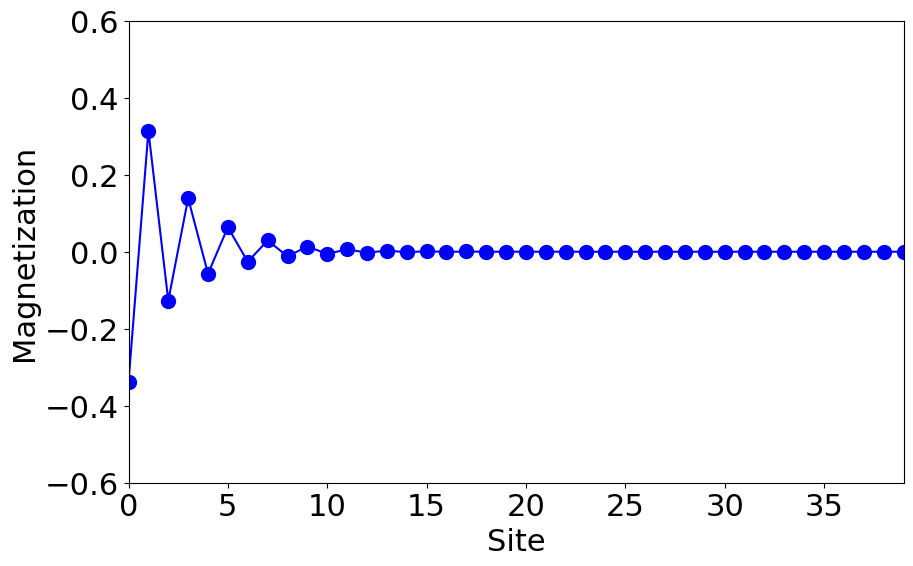

In [16]:
from dmrgpy import spinchain
n = 40 # length of the system
spins = ["S=1/2" for i in range(n)] # S=1 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1):
    J = 1.0 + .2*(-1)**i
    h = h + J*sc.Sx[i]*sc.Sx[i+1]
    h = h + J*sc.Sy[i]*sc.Sy[i+1]
    h = h + J*sc.Sz[i]*sc.Sz[i+1]

    
Bz = 1. # local magnetization
h = h + Bz*sc.Sz[0]
    
sc.set_hamiltonian(h) # create the Hamiltonian
iis = range(n)
cs = [sc.vev(sc.Sz[i],mode="DMRG") for i in iis]

plt.figure(figsize=(10,6))
plt.plot(iis,cs,marker="o",c="blue",markersize=10)
plt.xlabel("Site") ; plt.ylabel("Magnetization") ; plt.ylim([-0.6,0.6]) ; plt.xlim([min(iis),max(iis)])

### Quiz
- Why is the local magnetization decreasing?
- Why is the decrease much faster than the case above?
- Remove the XX and YY couplings. What happens and why?

## Magnetization of many-body excitations in large quantum chains
We will now see what is the magnetization profile of the excited states of a many-body spin chain

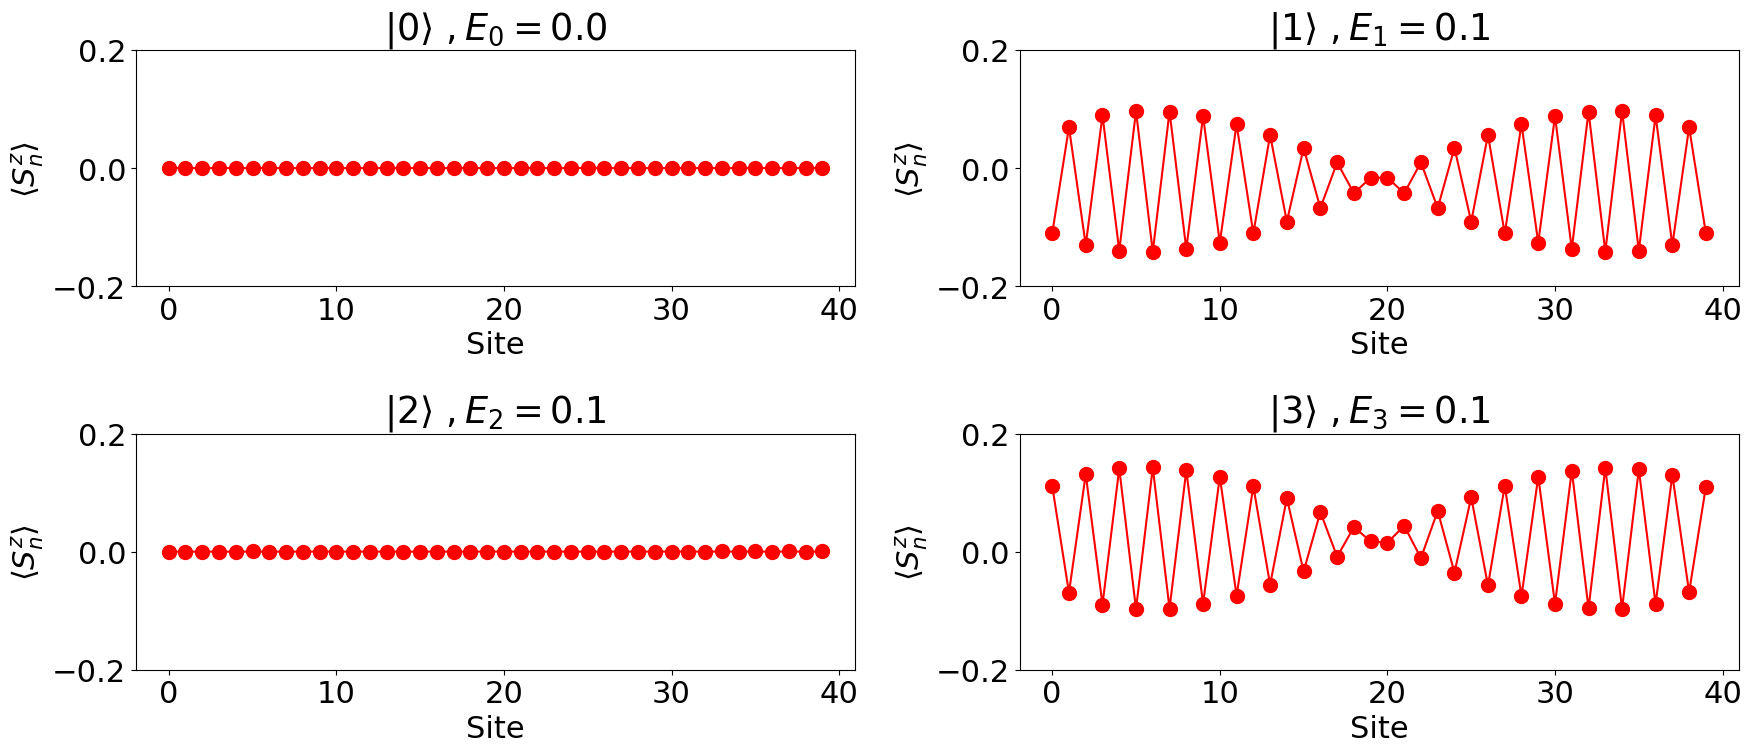

In [17]:
from dmrgpy import spinchain

L = 40 # number of spins

spins = ["S=1/2" for i in range(L)] # four S=1/2 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
for i in range(len(spins)-1): # Heisenberg coupling
    h = h + sc.Sx[i]*sc.Sx[i+1] ; h = h + sc.Sy[i]*sc.Sy[i+1] ; h = h + sc.Sz[i]*sc.Sz[i+1]
Bz = 0.01 # small magnetic field
h = h + Bz*sum(sc.Sz) # add external field
sc.maxm = 20 # modest bond dimension to accelerate the calculation
sc.set_hamiltonian(h) # set the Hamiltonian
nex = 4 # number of excited states
es,wfs = sc.get_excited_states(n=nex,mode="DMRG") # compute energies and excited states
es = es - es[0] # energy with respect to the ground state

plt.figure(figsize=(18,8))
ii = 1 # counter
for (e,wf) in zip(es,wfs): # loop
    plt.subplot(2,nex//2,ii) ; ii +=1 # subplot and increase
    mzs = [wf.dot(sz*wf) for sz in sc.Sz] # magnetization
    plt.plot(range(len(mzs)),mzs,marker="o",markersize=10,c="red") # plot
    plt.ylim([-0.2,0.2]) ; plt.ylabel("$\\langle S^z_n \\rangle$") ; plt.xlabel("Site")
    plt.title("$|$"+str(ii-2) + "$\\rangle$ $, E_"+str(ii-2)+" = $"+str(np.round(e,1)))
plt.tight_layout()

### Quiz
- Make the system smaller, what happens and why?
- Why are there two flat profiles?
- Why do states |1> and |3> have opposite profiles?

## Gap of a many-body spin chain
We will now see how the gap for a many-body spin chain scales with the system size, both for a pristine heisenberg model and a dimerized one

(0.0, 1.0)

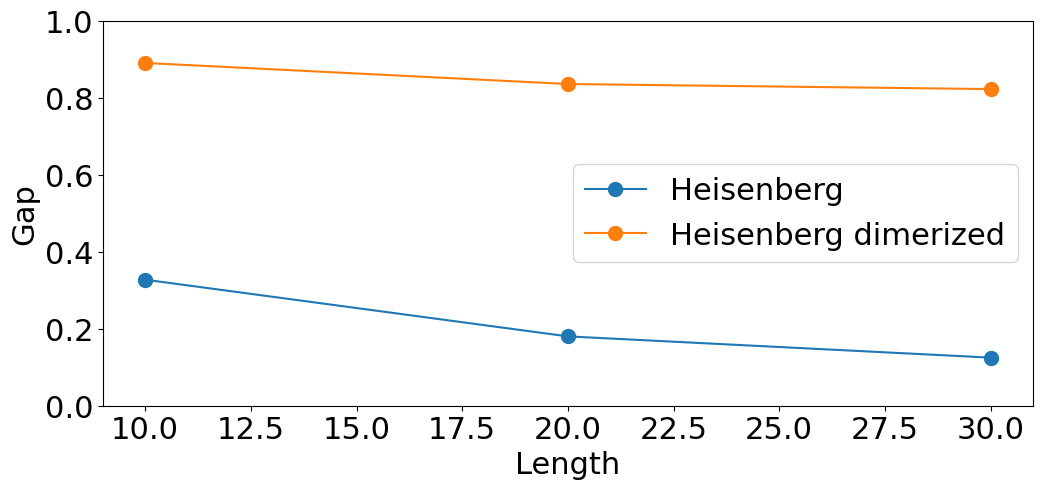

In [18]:
from dmrgpy import spinchain

def get_gap(n=20,dJ=0.):
    spins = ["S=1/2" for i in range(n)] # S=1/2 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1):
        J = 1.0 + dJ*(-1)**i
        h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    sc.maxm = 30 # to accelerate the calculation
    sc.set_hamiltonian(h) # create the Hamiltonian
    es = sc.get_excited(n=2,mode="DMRG") # get excited state energies
    g = es[1]-es[0] # energy to the first excited state
    return g # return the many-body gap

Ls = [10,20,30] # lengths of the system to consider
gaps = [get_gap(n=L,dJ=0.) for L in Ls] # gaps for the Heisenberg model
gaps_dim = [get_gap(n=L,dJ=0.3) for L in Ls] # gaps for the dimerized Heisenberg model

plt.figure(figsize=(12,5))
plt.plot(Ls,gaps,label="Heisenberg",marker="o",markersize=10)
plt.plot(Ls,gaps_dim,label="Heisenberg dimerized",marker="o",markersize=10)
plt.legend()
plt.xlabel("Length") ; plt.ylabel("Gap") ; plt.ylim([0.,1.0])

### Quiz
- What would be the gap in the limit of infinite length for both chains?
- What is the consequence in terms of how the magnetization around an impurity decreases as shown in the examples above?

## Non-local static correlators in a large system
We will now see how the non-local static correlators allow infering which system has the strongest gap

Text(0, 0.5, '$log|\\langle S_0^x S_N^x \\rangle |$')

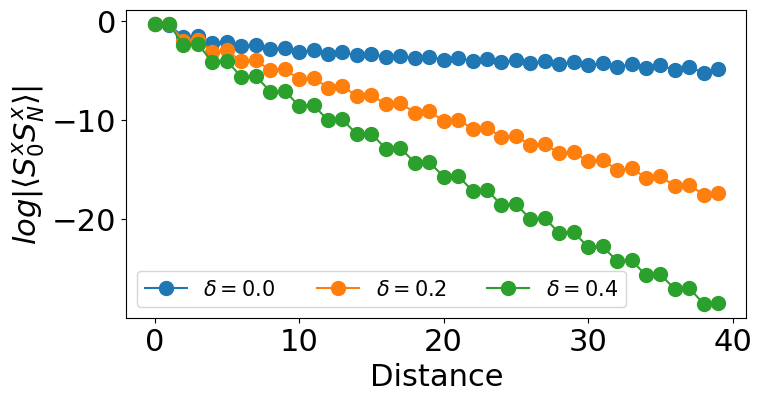

In [19]:
from dmrgpy import spinchain

def get_correlator(n=20,dJ=0.):
    spins = ["S=1/2" for i in range(n)] # S=1 in each site
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1):
        J = 1.0 + dJ*(-1)**i
        h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    sc.set_hamiltonian(h) # create the Hamiltonian
    wf0 = sc.get_gs(mode="DMRG") # compute ground state
    return [3*wf0.dot((sc.Sx[0]*sc.Sx[i])*wf0).real for i in range(n)]

plt.figure(figsize=(8,4))

dJs = [0.,0.2,0.4] # dimerizations
for dJ in dJs:
    cij = get_correlator(n=40,dJ=dJ)
    plt.plot(range(len(cij)),np.log(np.abs(cij)),label="$\\delta =$"+str(dJ),marker="o",markersize=10)

plt.legend(ncol=len(dJs),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$log|\\langle S_0^x S_N^x \\rangle |$") 

### Quiz
- Which parameter would lead to the biggest gap in the thermodynamic limit
- Make the system bigger, what do you observe?
- How can you know if some of the systems will be gapless in the thermodynamic limit?

## Fractionalization in the S=1 Heisenberg model
We will now see how the S=1 Heisenberg model features fractional topologicla edge modes

(0.0, 39.0)

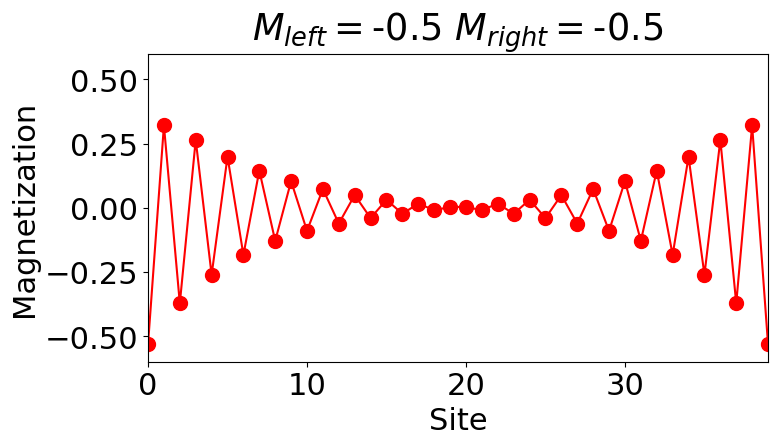

In [20]:
from dmrgpy import spinchain
n = 40 # length of the system
spins = ["S=1" for i in range(n)] # S=1 in each site
sc = spinchain.Spin_Chain(spins) # create spin chain object
h = 0 # initialize Hamiltonian
J = 1.0
for i in range(len(spins)-1):
    h = h + J*sc.Sx[i]*sc.Sx[i+1]
    h = h + J*sc.Sy[i]*sc.Sy[i+1]
    h = h + J*sc.Sz[i]*sc.Sz[i+1]

Bz = 0.2 # local magnetization
h = h + Bz*sum(sc.Sz) # add a magnetic field everywhere
    
sc.set_hamiltonian(h) # create the Hamiltonian
iis = range(n) # indexes
Mzs = [sc.vev(sc.Sz[i],mode="DMRG").real for i in iis] # local magnetization

fig = plt.figure(figsize=(8,4))
Ml = sum([Mzs[i] for i in range(0,n//2)]) # left magnetization
Mr = sum([Mzs[i] for i in range(n//2,n)]) # right magnetization
plt.title("$M_{left}  = $"+str(np.round(Ml,1)) + " $M_{right}  = $"+str(np.round(Mr,1)))
plt.plot(iis,Mzs,marker="o",c="red",markersize=10)
plt.xlabel("Site") ; plt.ylabel("Magnetization") ; plt.ylim([-0.6,0.6]) ; plt.xlim([min(iis),max(iis)])

### Quiz
- What happens if you make the system smaller, and why?
- What happens if you make the system bigger, and why?
- What do you expect to be the degeneracy of the ground state in the thermodynamic limit?

## Non-local correlator in the S=1/2 and S=1 Heisenberg models

Text(0, 0.5, '$log|\\langle S_0^x S_N^x \\rangle |$')

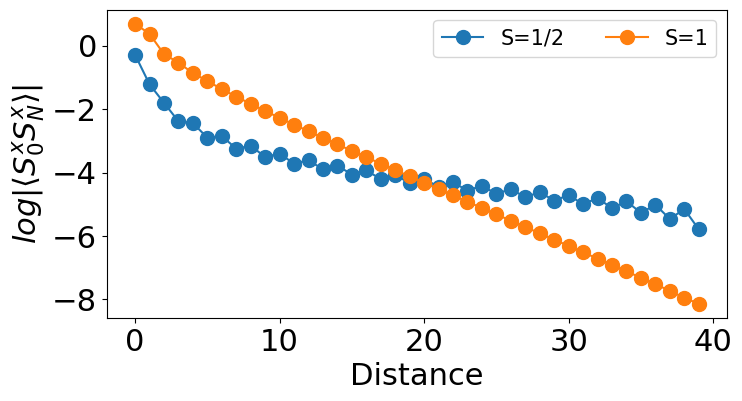

In [21]:
from dmrgpy import spinchain

def get_correlator(n=10,S="S=1/2"):
    spins = ["S=1/2"] + [S for i in range(n)] + ["S=1/2"] # S chain with S=1/2 at the edges
    sc = spinchain.Spin_Chain(spins) # create spin chain object
    h = 0 # initialize Hamiltonian
    for i in range(len(spins)-1):
        J = 1.0 
        h = h + J*sc.Sx[i]*sc.Sx[i+1] ; h = h + J*sc.Sy[i]*sc.Sy[i+1] ; h = h + J*sc.Sz[i]*sc.Sz[i+1]
    sc.set_hamiltonian(h) # create the Hamiltonian
    wf0 = sc.get_gs(mode="DMRG") # compute ground state
    return [3*wf0.dot((sc.Sx[1]*sc.Sx[i])*wf0).real for i in range(1,n+1)] # compute correlator

plt.figure(figsize=(8,4))

Ss = ["S=1/2","S=1"] # different spins
for S in Ss:
    cij = get_correlator(n=40,S=S)
    plt.plot(range(len(cij)),np.log(np.abs(cij)),label=S,marker="o",markersize=10)

plt.legend(ncol=len(dJs),fontsize=15)
plt.xlabel("Distance") ; plt.ylabel("$log|\\langle S_0^x S_N^x \\rangle |$") 

### Quiz
- What is the biggest system size that you could have done with exact diagonalization?
- Why have we included a S=1/2 at the beginning and end of the chain for S=1?
- What does it mean that the correlator decays exponentially?